# Impact of neighborhood characteristics on housing prices

# 1. Introduction

Housing price prediction is an interesting topic for many of us, whether you are in the real estate industry trying to make money buying and selling houses, or you just want to purchase a decent house for yourself with a reasonable price. However, prediction is not an easy job since there are many factors affecting the house prices, such as living area, year of construction, location, number of bedrooms, number of bathrooms. 

In this project we are going to investigate the impact of the neighborhood characteristics on housing prices. We are going to answer two main questions:

1. Does information on the neighborhood characteristics help to improve housing prices prediction?
2. If it does, what types of neighborhoods are likely to have higher housing prices? 

# 2. Methodology
We will look for the answers to the above questions using a data science approach. Two datasets are explored in this project: a New York housing price dataset from [Realtor](https://www.realtor.com/), which contains information on houses sold recently in New York, and a New York neighborhood information dataset from [Foursquare](https://developer.foursquare.com/), which contains neighborhoods' recommended venues. Based on the datasets, two prediction models will be generated. The first model uses only the housing price dataset, while the second model uses the housing price dataset in combination with the neighborhood information dataset. The models are built and trained using the multi linear regression method. The performances of the two models are then compared to see if the neighborhood information improves the prediction. If it does, we will further investigate how the characteristics of the neighborhoods affect the housing prices.

Before we start, let us import the libraries needed for this analysis:

In [1]:
import pandas as pd
import numpy as np
import requests
import json

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

import matplotlib.pyplot as plt

# 3. Data
For this analysis we will use the following 2 datasets
1. New York housing prices dataset from [Realtor](https://www.realtor.com/): this dataset contains a list of houses sold recently in New York, together with their information such as lot size, location, year built, number of bedrooms and so on. 
2. New York neighborhood information dataset from [Foursquare](https://developer.foursquare.com/): this dataset contains a list of New York's neighborhood and their recommended venues.

## 3.1. New York housing prices data
### Data importing
The New York housing prices dataset from [Realtor](https://www.realtor.com/) is imported using the [Realtor API](https://rapidapi.com/apidojo/api/realtor). The dataset contains a list of houses sold recently in New York together with their information. For the purpose of sharing this notebook without revealing my API credentials, I have downloaded and save the data to a json file. Let us now load the data from the json file:


In [2]:
json_filename = 'NY-list-sold.json'
with open(json_filename) as f:
    json_data = json.load(f)
f.close()     

housing_data = json_data['properties']

We will convert the data to a pandas dataframe:

In [3]:
# convert the data to a pandas dataframe
df_house_full = pd.json_normalize(housing_data)

# check the shape of the dataframe
print(df_house_full.shape)

(6364, 72)


We get a dataframe with 72 columns and 6364 data points. Not all data points are useful though. Let us first clean up the data.

### Data cleaning
First, let us drop the duplicated rows in the dataframe

In [4]:
# drop duplicates
df_house_full.drop_duplicates(subset ="property_id", keep = 'first', inplace = True) 

# check the shape of the dataframe
print(df_house_full.shape)
df_house_full.head()

(6075, 72)


,property_id,listing_id,prop_type,list_date,last_update,year_built,beds,baths_full,baths_half,prop_status,...,office.id,office.phones,building_size.size,building_size.units,office.advertiser_id,price_reduced_date,office.photo.href,lot_size.size,lot_size.units,garage
0,O3324614978,2870154772,condo,2019-12-23T21:36:02Z,2020-05-04T12:20:03Z,1964.0,2.0,1.0,NaN,not_for_sale,...,1c570f54a97857fa51eb9a423b20ce58,"[{'number': '718-265-2521', 'type': 'office', ...",1000.0,sqft,NaN,NaN,NaN,NaN,NaN,NaN
1,O9949620288,2512980267,condo,2019-10-29T14:06:43Z,2020-05-04T15:26:41Z,2019.0,2.0,2.0,NaN,not_for_sale,...,33fb537ee27bfbf0303f8cfd324d03e0,"[{'number': '718-232-1004', 'type': 'office', ...",1133.0,sqft,1513383.0,NaN,NaN,NaN,NaN,NaN
2,O4933762654,2465636145,condo,2019-07-09T14:25:59Z,2020-05-04T14:17:55Z,1960.0,2.0,1.0,1.0,not_for_sale,...,d0300f260f315de7c6eb8c5cecef2211,"[{'number': '718-835-4700', 'type': 'office', ...",NaN,NaN,237734.0,2019-09-30T14:03:40.892Z,https://ap.rdcpix.com/1222035238/37615fd556d59...,12222.0,sqft,NaN
3,O9359213003,2756391634,condo,2019-10-25T17:43:21Z,2020-05-01T19:58:54Z,1957.0,1.0,1.0,NaN,not_for_sale,...,f61053eabb4db1531dcf98b44737904e,"[{'number': '929-222-4200', 'type': 'home', 'p...",775.0,sqft,1958993.0,2020-01-01T21:32:32.293Z,https://p.rdcpix.com/v01/o51e41d00-c0l.gif,NaN,NaN,NaN
4,O4635149680,2854255611,multi_family,2019-12-12T20:25:51Z,2020-05-04T13:49:51Z,1920.0,3.0,3.0,NaN,not_for_sale,...,99df1bf8266bd14faf4f4346e77479de,"[{'number': '855-954-2107', 'type': 'office', ...",1175.0,sqft,3213197.0,NaN,https://ap.rdcpix.com/1111013323/939782dee6b48...,1500.0,sqft,NaN


We can see that there are columns which are not informative for our housing price prediction such as 'listing_id', 'prop_status', 'office.phones'. Let us create a new dataframe which contains only the features which are relevant to the house price:

In [5]:
# select relevant features
df_house_cols = [ 'property_id','prop_type','beds', 'baths_full', 'baths', 
                  'year_built', 'lot_size.size','building_size.size', 
                  'address.neighborhood_name', 'address.postal_code','address.lat','address.lon',
                  'price']
df_house = df_house_full[df_house_cols]

Some features' names are quite long. We will shorten some of them for our convenience:

In [6]:
# shorten column names
df_house = df_house.rename(columns={"address.neighborhood_name": "neighborhood", 
                                    "address.postal_code": "postal_code",
                                    "address.lat": "lat",
                                    "address.lon": "lon",
                                    "lot_size.size": "lot_size", 
                                    "building_size.size": "building_size"})
df_house.head()

,property_id,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,neighborhood,postal_code,lat,lon,price
0,O3324614978,condo,2.0,1.0,1.0,1964.0,NaN,1000.0,"Coney Island - Brooklyn,NY",11224,40.578851,-73.969859,440000
1,O9949620288,condo,2.0,2.0,2.0,2019.0,NaN,1133.0,"Bath Beach - Brooklyn,NY",11214,40.603675,-74.002613,728000
2,O4933762654,condo,2.0,1.0,2.0,1960.0,12222.0,NaN,NaN,11414,NaN,NaN,360000
3,O9359213003,condo,1.0,1.0,1.0,1957.0,NaN,775.0,"Riverdale - Bronx,NY",10463,40.883872,-73.911068,190500
4,O4635149680,multi_family,3.0,3.0,3.0,1920.0,1500.0,1175.0,"Sheepshead Bay - Brooklyn,NY",11229,40.596440,-73.955704,799000


We will now drop all rows with NaN values:

In [7]:
# Drop rows with NaN values
df_house.dropna(axis='index',inplace=True)

print(df_house.shape)
df_house.head()

(1596, 13)


,property_id,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,neighborhood,postal_code,lat,lon,price
4,O4635149680,multi_family,3.0,3.0,3.0,1920.0,1500.0,1175.0,"Sheepshead Bay - Brooklyn,NY",11229,40.596440,-73.955704,799000
8,O3100293204,multi_family,2.0,1.0,1.0,1899.0,4000.0,1752.0,"South Shore - Staten Island,NY",10307,40.507548,-74.251220,627900
9,O3154267434,multi_family,5.0,3.0,3.0,1960.0,2200.0,2200.0,"Canarsie - Brooklyn,NY",11236,40.644589,-73.888601,750000
10,O3971533857,single_family,3.0,1.0,2.0,1930.0,2500.0,1404.0,"Auburndale - Queens,NY",11360,40.771425,-73.787866,800000
11,O3981442835,multi_family,4.0,3.0,4.0,2018.0,5781.0,3057.0,"Pleasant Plains - Staten Island,NY",10309,40.522243,-74.221881,1135000


Let us remove the borough part in the 'neighborhood' column:

In [8]:
df_house['neighborhood']=df_house['neighborhood'].str.replace("\s-\s\D*",'')
df_house.head()

,property_id,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,neighborhood,postal_code,lat,lon,price
4,O4635149680,multi_family,3.0,3.0,3.0,1920.0,1500.0,1175.0,Sheepshead Bay,11229,40.596440,-73.955704,799000
8,O3100293204,multi_family,2.0,1.0,1.0,1899.0,4000.0,1752.0,South Shore,10307,40.507548,-74.251220,627900
9,O3154267434,multi_family,5.0,3.0,3.0,1960.0,2200.0,2200.0,Canarsie,11236,40.644589,-73.888601,750000
10,O3971533857,single_family,3.0,1.0,2.0,1930.0,2500.0,1404.0,Auburndale,11360,40.771425,-73.787866,800000
11,O3981442835,multi_family,4.0,3.0,4.0,2018.0,5781.0,3057.0,Pleasant Plains,10309,40.522243,-74.221881,1135000


The 'prop_type' is an important feature for price prediction. Let us explore the property types present in the dataset:

In [9]:
df_prop_types=df_house['prop_type'].value_counts()
df_prop_types

single_family    641
condo            493
multi_family     461
mobile             1
Name: prop_type, dtype: int64

For regression purpose, we will convert the property types to integer values as follows:
- 'condo' = 0
- 'single_family' = 1
- 'multi_family' = 2

The only one 'mobile' property will be droped.

In [10]:
# drop the 'mobile' property
df_house.drop(df_house[df_house['prop_type']=='mobile'].index, inplace=True)

# convert property types to integer values
df_house['prop_type'].replace(to_replace=['condo','single_family','multi_family'], value=[0,1,2],inplace=True)

df_house.head()

,property_id,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,neighborhood,postal_code,lat,lon,price
4,O4635149680,2,3.0,3.0,3.0,1920.0,1500.0,1175.0,Sheepshead Bay,11229,40.596440,-73.955704,799000
8,O3100293204,2,2.0,1.0,1.0,1899.0,4000.0,1752.0,South Shore,10307,40.507548,-74.251220,627900
9,O3154267434,2,5.0,3.0,3.0,1960.0,2200.0,2200.0,Canarsie,11236,40.644589,-73.888601,750000
10,O3971533857,1,3.0,1.0,2.0,1930.0,2500.0,1404.0,Auburndale,11360,40.771425,-73.787866,800000
11,O3981442835,2,4.0,3.0,4.0,2018.0,5781.0,3057.0,Pleasant Plains,10309,40.522243,-74.221881,1135000


Next, let us investigate the lot_size and building size:

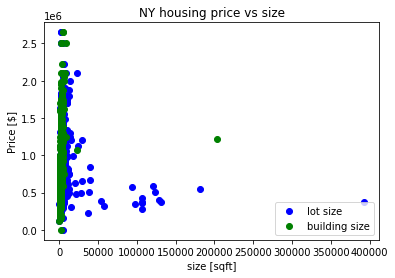

In [11]:
plt.scatter(df_house['lot_size'],df_house['price'], color='blue', label='lot size')
plt.scatter(df_house['building_size'],df_house['price'], color='green', label='building size')
plt.title('NY housing price vs size')
plt.xlabel('size [sqft]')
plt.ylabel('Price [$]')
plt.legend(loc='lower right')
plt.show()

We observe that there are some suspicious data points where the size is very large but the price is relatively low. For this reason, let us drop all the data points with lot_size and building size larger than 20000 square feet:

In [12]:
df_house.drop(df_house[df_house['lot_size']>20000].index, inplace=True)
df_house.drop(df_house[df_house['building_size']>20000].index, inplace=True)

print(df_house.shape)

(1568, 13)


Finally, let us reset the index of the dataframe

In [13]:
# reset index
df_house.reset_index(drop=True, inplace=True)
df_house.head()

,property_id,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,neighborhood,postal_code,lat,lon,price
0,O4635149680,2,3.0,3.0,3.0,1920.0,1500.0,1175.0,Sheepshead Bay,11229,40.596440,-73.955704,799000
1,O3100293204,2,2.0,1.0,1.0,1899.0,4000.0,1752.0,South Shore,10307,40.507548,-74.251220,627900
2,O3154267434,2,5.0,3.0,3.0,1960.0,2200.0,2200.0,Canarsie,11236,40.644589,-73.888601,750000
3,O3971533857,1,3.0,1.0,2.0,1930.0,2500.0,1404.0,Auburndale,11360,40.771425,-73.787866,800000
4,O3981442835,2,4.0,3.0,4.0,2018.0,5781.0,3057.0,Pleasant Plains,10309,40.522243,-74.221881,1135000


## 3.2. New York neighborhoods data
### Data importing

This dataset contains the neighborhoods' recommended venues from [Foursquare](https://developer.foursquare.com/). In order to import neighborhoods' recommended venues from Foursquare, we first need the latitudes and longitudes of the neighborhoods, which can be imported from [https://geo.nyu.edu/catalog/nyu_2451_34572](https://geo.nyu.edu/catalog/nyu_2451_34572):

In [14]:
# Download the geospatial data csv file
import wget
geodata_url = 'https://cocl.us/new_york_dataset'
nbhfilename = wget.download(geodata_url)

with open(nbhfilename) as json_data:
    newyork_data = json.load(json_data)
json_data.close()

neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

100% [............................................................................] 115774 / 115774

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

The json data contains information on the neighborhoods in New York. Let us extract the neighborhoods' names and their coordinates to a dataframe:

In [15]:
# define the dataframe columns
column_names = ['neighborhood', 'neighborhood_lat', 'neighborhood_lon'] 

# instantiate the dataframe
df_nbh = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_nbh = df_nbh.append({'neighborhood': neighborhood_name,
                            'neighborhood_lat': neighborhood_lat,
                            'neighborhood_lon': neighborhood_lon}, ignore_index=True)

# drop some duplicate neighborhoods with wrong data
df_nbh=df_nbh.drop(index=[175,180,220,244])
    
print(df_nbh.shape)
df_nbh.head()    

(302, 3)


,neighborhood,neighborhood_lat,neighborhood_lon
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


Note that many neighborhoods in this dataset do not appear in our housing prices dataset, which is therefore not interesting for us. Let us find only the neighborhoods that appear in both datasets:

In [16]:
# merge the neighborhood and the housing dataframe
df_total = pd.merge(df_nbh, df_house, how='inner', on='neighborhood')

# move the 'property_id' column to the first column
df_total = df_total[ ['property_id'] + [ col for col in df_total.columns if col != 'property_id' ] ]

# extract the unique neighborhood from the dataframe
df_nbh_unique = df_total[['neighborhood',
                          'neighborhood_lat',
                          'neighborhood_lon']].drop_duplicates(subset ="neighborhood", keep = 'first') 
# reset index
df_nbh_unique.reset_index(drop=True, inplace=True)

print('There are {} neighborhoods that appear in both datasets.'.format(len(df_nbh_unique['neighborhood'])))
df_nbh_unique.head()

There are 104 neighborhoods that appear in both datasets.


,neighborhood,neighborhood_lat,neighborhood_lon
0,Wakefield,40.894705,-73.847201
1,Eastchester,40.887556,-73.827806
2,Morris Heights,40.847898,-73.919672
3,Unionport,40.829774,-73.850535
4,Bay Ridge,40.625801,-74.030621


We are now ready to import data from Foursquare. First I will read my Foursquare credentials from a local csv file:

In [17]:
# read Foursqrare credentials from a local csv file
Foursquare_credentials = pd.read_csv('Foursquare_Credentials.csv')
CLIENT_ID = Foursquare_credentials.loc[0,'CLIENT_ID']
CLIENT_SECRET = Foursquare_credentials.loc[0,'CLIENT_SECRET']
VERSION = '20200101' # Foursquare API version

Let us define a function to import recommended venues from Foursquare using Foursquare API 'explore' call:

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let us use the above function to import the recommended venues for each neighborhood from Foursquare:

In [19]:
df_venues = getNearbyVenues(names=df_nbh_unique['neighborhood'],
                            latitudes=df_nbh_unique['neighborhood_lat'],
                            longitudes=df_nbh_unique['neighborhood_lon'] )

print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))
df_venues.head()

Wakefield
Eastchester
Morris Heights
Unionport
Bay Ridge
Bensonhurst
Sunset Park
Gravesend
Brighton Beach
Sheepshead Bay
Prospect Heights
Brownsville
Williamsburg
Bushwick
Cypress Hills
East New York
Canarsie
Flatlands
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Sea Gate
City Line
Bergen Beach
Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Arverne
Floral Park
Jamaica Estates
Hillcrest
Laurelton
Brookville
New Brighton
Rosebank
Todt Hill
South Beach
Travis
Oakwood
Great Kills
Woodrow
Grasmere
Midland Beach
New Dorp Beach
Bay Terrace
Pleasant Pla

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let us take a look at the most popular venue categories in the dataset. It is no surprise that Pizza Place is the most popular places :D

In [20]:
df_venues_count=df_venues['Venue Category'].value_counts()

df_venues_count.head()

Pizza Place           102
Deli / Bodega          83
Chinese Restaurant     71
Pharmacy               68
Bakery                 60
Name: Venue Category, dtype: int64

The data have been imported successfully. Now we will clean and prepare the data.

### Data cleaning
We will use one hot encoding to convert each venue category to a column:

In [21]:
# one hot encoding
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_venues_onehot['neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
df_venues_onehot = df_venues_onehot[ ['neighborhood'] + [ col for col in df_venues_onehot.columns if col != 'neighborhood' ] ]

print(df_venues_onehot.shape)
df_venues_onehot.head()

(2422, 281)


,neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let us group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [22]:
df_venues_grouped = df_venues_onehot.groupby('neighborhood').mean().reset_index()
df_venues_grouped.head()

,neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Arden Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
1,Arverne,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.055556,0.0,0.00000,0.0
2,Astoria,0.0,0.0,0.010204,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010204,0.00000,0.0,0.0,0.0,0.0,0.010204,0.0,0.00000,0.0
3,Auburndale,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
4,Bath Beach,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.02381,0.0,0.0,0.0,0.0,0.000000,0.0,0.02381,0.0


Finally let us create a dataframe that combines both housing data and neighborhoods' venues data:

In [23]:
df = pd.merge(df_venues_grouped, df_total, how='inner', on='neighborhood')

# move the 'property_id' column to the first column
df = df[ ['property_id'] + [ col for col in df.columns if col != 'property_id' ] ]

print(df.shape)
df.head()

(1034, 295)


,property_id,neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,beds,baths_full,baths,year_built,lot_size,building_size,postal_code,lat,lon,price
0,O4985984011,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,2.0,1970.0,1488.0,1376.0,10312,40.555243,-74.196336,470000
1,O4389954453,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,1925.0,4000.0,1201.0,10312,40.547307,-74.192839,370000
2,O3402580008,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,1986.0,640.0,980.0,10312,40.552280,-74.199922,261500
3,O4761792101,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,1979.0,1330.0,1441.0,10312,40.550653,-74.191594,353000
4,O3575117743,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,3.0,1981.0,2340.0,1800.0,10312,40.549002,-74.199929,725000


The data set is now ready.

## 4. Prediction models
The datasets have been imported and cleaned. We are now ready to build multi linear regression models to predict housing price in New York. We will generate 2 models, one with housing data only, and another with both housing data and neighborhood information. The performances of the 2 models will be compared to see how the neighborhood information affects the prediction.

### 4.1. Prediction model using housing data only
#### Build and train model
First we will create a features dataframe with housing features only:

In [24]:
df_features1 = df[['prop_type','beds','baths_full','baths','year_built',
                    'lot_size','building_size','postal_code','lat','lon']]
print(df_features1.shape)
df_features1.head()

(1034, 10)


,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,postal_code,lat,lon
0,1,3.0,2.0,2.0,1970.0,1488.0,1376.0,10312,40.555243,-74.196336
1,1,3.0,1.0,1.0,1925.0,4000.0,1201.0,10312,40.547307,-74.192839
2,0,2.0,1.0,2.0,1986.0,640.0,980.0,10312,40.552280,-74.199922
3,0,2.0,1.0,2.0,1979.0,1330.0,1441.0,10312,40.550653,-74.191594
4,0,3.0,2.0,3.0,1981.0,2340.0,1800.0,10312,40.549002,-74.199929


Let us define X and y for our dataset. We will preprocess and split them into train set and test set:

In [25]:
# define X and y
X1 = np.asanyarray(df_features1)
y1 = np.asanyarray(df[['price']])

# scaler
X1 = preprocessing.StandardScaler().fit(X1).transform(X1)

# train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)                       

We will now define our multi linear regression model and train it with the train dataset:

In [26]:
# create linear regression model
lr1 = linear_model.LinearRegression()

# train the model
lr1.fit(X1_train, y1_train)

# check the score
print('Prediction score: {}'.format(lr1.score(X1_test,y1_test)))

Prediction score: 0.5811022497550755


#### Results
The multi linear regression model has a prediction score of 0.58. This is not a great score, but at least it gives us some ideas on the relations between the house's features and its price. We will take a look at some of these relations. Let us first define a function to plot the relations between a feature and the price:

In [27]:
def feature_vs_price(feature_names, df_features, X, y, lr, plotdata):
    for feature_name in feature_names:
        # define the feature
        feature_index= df_features.columns.get_loc(feature_name)
        feature_X = X[:,feature_index]
        
        # regression model parameters
        feature_coef = lr.coef_[:,feature_index]
        feature_intercept = lr.intercept_
        
        # calculate the prediction
        feature_Xlin = np.array([min(feature_X), max(feature_X)])
        feature_yhat = feature_intercept + feature_coef*feature_Xlin
        
        # get original unscaled data for plotting
        X0 = np.asanyarray(df_features)
        feature_X0 = X0[:,feature_index]
        feature_X0lin = np.array([min(feature_X0), max(feature_X0)])
        
        # plotting
        if plotdata:
            plt.scatter(feature_X0, y, label=feature_name+' data')
            plt.plot(feature_X0lin, feature_yhat, color='red', label=feature_name+' prediction')
            plt.title('NY housing price vs '+feature_name)
            plt.xlabel(feature_name)
        else:
            plt.plot(feature_X0lin, feature_yhat, label=feature_name+' prediction')
            plt.title('NY housing price')
        
        plt.ylabel('Price [$]')
    plt.legend(loc='lower right')
    plt.show()

Let us investigate the relation between lot_size and house price. As expected, our model predicts that the price increases with the lot size.

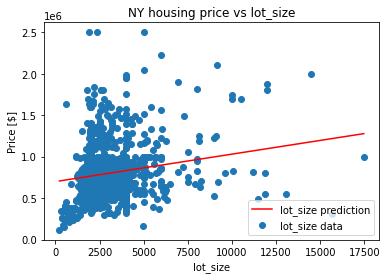

In [28]:
feature_vs_price(['lot_size'], df_features1, X1, y1, lr1, 1)

Next, let us check the impact of number of bedrooms on house price. The model predicts that houses with more bedrooms are more expensive as we expected.

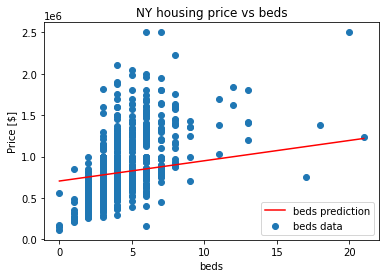

In [29]:
feature_vs_price(['beds'], df_features1, X1, y1, lr1, 1)

### 4.2. Prediction model using housing data and neighborhood data
#### Build and train model
Now let us incorporate the neighborhood data into our prediction model to see if it helps to improve the prediction accuracy. We will not take all the venue categories into account because many of them have very low number of appearances and show up in only 1 or 2 neighborhoods, which is not very informative and may even lower our prediction accuracy. Let us consider only the top 50 most popular venue categories:

In [30]:
# find top 50 most popular venue categories
venue_categories_top50 = df_venues_count[0:50].index.tolist()
venue_categories_top50[0:5]

['Pizza Place', 'Deli / Bodega', 'Chinese Restaurant', 'Pharmacy', 'Bakery']

Let us now add the top 50 venue categories to our housing features dataframe to create a new dataframe. The new dataframe contains both housing features and neighborhoods' venues features:

In [31]:
# add top 50 venue categrories to df_features1 to create a new dataframe
df_features2 = pd.concat( [ df_features1, df[venue_categories_top50] ], axis=1 )

print(df_features2.shape)
df_features2.head()

(1034, 60)


,prop_type,beds,baths_full,baths,year_built,lot_size,building_size,postal_code,lat,lon,...,Discount Store,Spanish Restaurant,Dessert Shop,Greek Restaurant,Seafood Restaurant,Lounge,Middle Eastern Restaurant,Korean Restaurant,Pet Store,South American Restaurant
0,1,3.0,2.0,2.0,1970.0,1488.0,1376.0,10312,40.555243,-74.196336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3.0,1.0,1.0,1925.0,4000.0,1201.0,10312,40.547307,-74.192839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2.0,1.0,2.0,1986.0,640.0,980.0,10312,40.552280,-74.199922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2.0,1.0,2.0,1979.0,1330.0,1441.0,10312,40.550653,-74.191594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3.0,2.0,3.0,1981.0,2340.0,1800.0,10312,40.549002,-74.199929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let us define X and y for our dataset. We will preprocess and split them into train set and test set:

In [32]:
# define X and y
X2 = np.asanyarray(df_features2)
y2 = np.asanyarray(df[['price']])

# scaler
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)

# train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)                       

We will now define our multi linear regression model and train it with the train dataset:

In [33]:
# create linear regression model
lr2 = linear_model.LinearRegression()

# train the model
lr2.fit(X2_train, y2_train)

# check the score
print('Prediction score: {}'.format(lr2.score(X2_test,y2_test)))

Prediction score: 0.7069052978496869


#### Results
We can see that the prediction score has increases considerably from 0.58 to 0.71. This proves that the neighborhood information does help to increase prediction accuracy. Our first research question has been answered.

## 5. Discussion: neighborhood characteristics and housing prices
We will now investigate how the characteristics of the neighborhoods impact the housing prices. Let us first investigate the most popular venue category which is pizza places. From the plot we can see our model predict that the more pizza places are in the neighborhood, the lower the house prices will be.

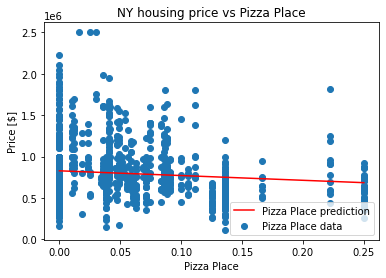

In [34]:
feature_vs_price(['Pizza Place'], df_features2, X2, y2, lr2, 1)

Next let us take a look at the second most popular one, which is delis / bodegas. Our model also predicts an inverse linear relationship between the number of delis / bodegas and the house prices.

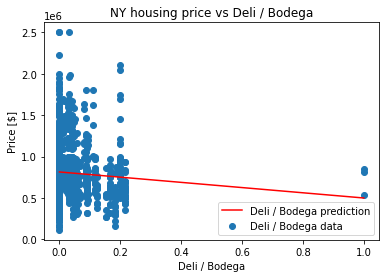

In [35]:
feature_vs_price(['Deli / Bodega'], df_features2, X2, y2, lr2, 1)

Perhaps people prefer quieter neighborhoods? Let us investigate the relation between parks and housing prices. Although not very significant, it looks like houses in neighborhoods with more parks are more expensive.

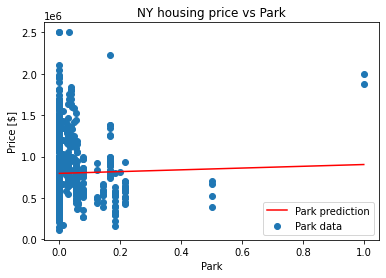

In [36]:
feature_vs_price(['Park'], df_features2, X2, y2, lr2, 1)

We will now investigate the relation between several types of restaurants and housing prices. It is interesting to see that the housing prices go up with the number of Italian and Mexican restaurants, but go down with the number of Chinese and Spanish restaurants.

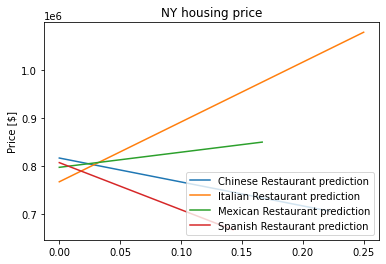

In [37]:
feature_vs_price(['Chinese Restaurant',
                  'Italian Restaurant',
                  'Mexican Restaurant',
                  'Spanish Restaurant'], df_features2, X2, y2, lr2, 0)

Another interesting venue category is bars. Although there is a positive linear relation, the impact of bars on housing price seems to be small.

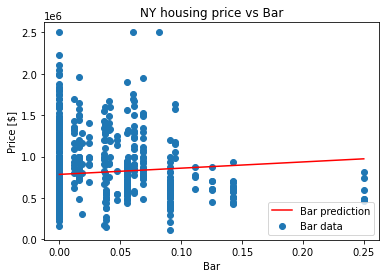

In [38]:
feature_vs_price(['Bar'], df_features2, X2, y2, lr2, 1)

The housing prices seems to decrease with the number of playgrounds.

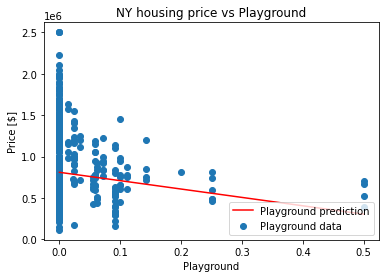

In [39]:
feature_vs_price(['Playground'], df_features2, X2, y2, lr2, 1)

The above-mentioned relations are not easy to explain. This opens up some interesting questions for further investigation. 

## 6. Conclusions
In this project we have used a data science approach to investigate the impact of neighborhood characteristics on housing prices. We have found the answers to our 2 research questions:

1. __Does information on the neighborhood characteristics help to improve housing prices prediction?__ <br>
The answer is that information on neighborhood characteristics indeed does help to improve the prediction accuracy. By incorporating the neighborhood information into the regression model, we increased the prediction score from 0.58 to 0.71.

2. __If it does, what types of neighborhoods are likely to have higher housing prices?__ <br>
With the trained regression model, we have found some interesting relations between neighborhoods and housing prices. It looks like the more pizza places and delis / bodegas are in the neighborhood, the lower the house prices will be. The price increases if there are more parks nearby. Another interesting observation is that the housing prices seems to go up with the number of Italian and Mexican restaurants, but go down with the number of Chinese and Spanish restaurants. These relations are not easy to explain, but this opens up interesting questions for further investigation. 

For future investigation it is also interesting to apply other advanced regression methods to this problem to see how the prediction is improved.
